# ¿Qué es el filtro de Bayer?

El filtro de Bayer, tambien conocido como mascara de Bayer, es una matriz de filtros que se situa sobre el CCD de las camaras digitales. Este tiene el objetivo de filtrar la luz incidente de tal manera que cada fotodiodo sobre el sensor reciba una luz monocromatica roja, verde o azul. 

A partir de la información extraida para cada canal de color se forman las imagenes digitales.
# ¿ Qué es Demosaicing?
Si vemos la salida raw de un sensor CCD con el correspondiente filtro de Bayer aplicado, podemos ver que esta lejos de parecerse a una imagen digital convencional. Para poder llevar esta imagen RAW al formato de pixel RGB que utilizamos en nuestras pantallas es necesario procesar la salida del CCD

# Lab2 RAW debayering1


Compilamos el dcraw y lo corremos sobre la imagen de muestra

In [1]:
%cd drive/Shareddrives/Imagenes/TP6\ Grupo1

/content/drive/Shareddrives/Imagenes/TP6 Grupo1


In [2]:
# Compilamos el programa
%%shell 
pwd
gcc -o dcraw -O4 dcraw.c -lm -DNODEPS
/content/drive/Shareddrives/Imagenes/TP6\ Grupo1/dcraw -4 -D -T /content/drive/Shareddrives/Imagenes/TP6\ Grupo1/sample.DNG

/content/drive/Shareddrives/Imagenes/TP6 Grupo1
dcraw.c: In function ‘get2’:
dcraw.c:306:3: warning: ignoring return value of ‘fread’, declared with attribute warn_unused_result [-Wunused-result]
   fread (str, 1, 2, ifp);
   ^~~~~~~~~~~~~~~~~~~~~~
dcraw.c: In function ‘get4’:
dcraw.c:322:3: warning: ignoring return value of ‘fread’, declared with attribute warn_unused_result [-Wunused-result]
   fread (str, 1, 4, ifp);
   ^~~~~~~~~~~~~~~~~~~~~~
dcraw.c: In function ‘canon_has_lowbits’:
dcraw.c:745:3: warning: ignoring return value of ‘fread’, declared with attribute warn_unused_result [-Wunused-result]
   fread (test, 1, sizeof test, ifp);
   ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
dcraw.c: In function ‘ljpeg_start’:
dcraw.c:828:5: warning: ignoring return value of ‘fread’, declared with attribute warn_unused_result [-Wunused-result]
     fread (data, 1, len, ifp);
     ^~~~~~~~~~~~~~~~~~~~~~~~~
dcraw.c: In function ‘nikon_e2100’:
dcraw.c:1297:5: warning: ignoring return value of ‘fread’, d

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!pwd

/content/drive/Shareddrives/Imagenes/TP6 Grupo1


In [5]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

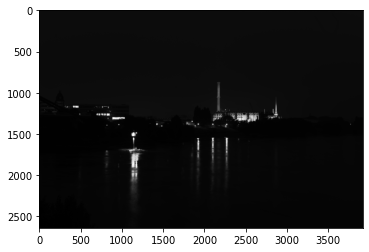

In [6]:
sample_tiff_path = 'sample.tiff'
raw_data = Image.open(sample_tiff_path)
raw = np.array(raw_data).astype(np.double)
plt.imshow(raw, cmap='gray');

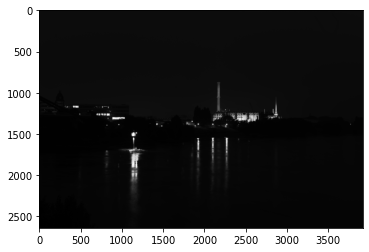

In [7]:
# # Step 1: Normalization
# # TODO 1: Map raw to range [0,1].
linear_bayer = raw/raw.max()
plt.imshow(linear_bayer, cmap='gray')
plt.show()

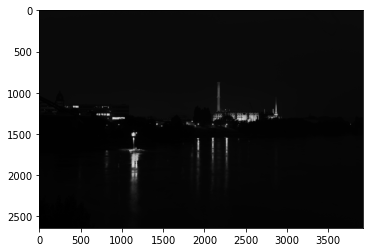

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


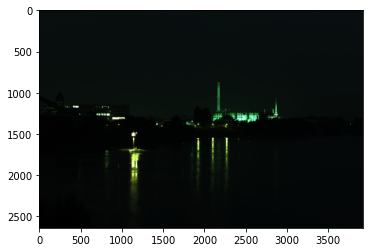

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


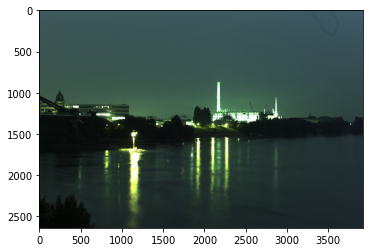

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


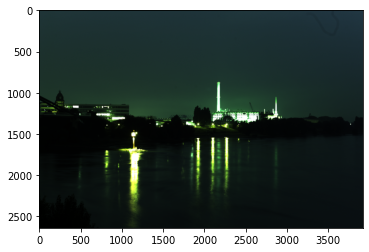

In [10]:
def wbscalematrix(m, n, wb_scales, align):
  # Makes a white-balance scaling matrix for an image of size m-by-n
  # from the individual RGB white balance scalar multipliers [wb_scales] = [R_scale G_scale B_scale].
  #
  # [align] is string indicating the 2x2 Bayer arrangement: 
  # 'rggb':  
  #    R G 
  #    G B 
  # 'gbrg':
  #    G B
  #    R G
  # 'grbg',
  #  G R 
  #  B G
  #'bggr' follow as before.
  # B G
  # G R

  # First, for convenience only, we're going to fill the scale matrix
  # with all green pixels. Then, we're going to replace the red and blue 
  # pixels later on with the correct scalars.
  #
  scalematrix = wb_scales[1] * np.ones((m,n)) # Initialize to all green values
  # G: 1::2
  # B: 0::2
  # R: 0::2

  # Fill in the scales for the red and blue pixels across the matrix
  if align == 'rggb':
    scalematrix[1::2, 1::2] = wb_scales[0] # r
    scalematrix[1::2, 1::2] = wb_scales[2] # b
    # TODO 2: Complete this case
  elif align == 'bggr':
    scalematrix[1::2, 1::2] = wb_scales[0] # r
    scalematrix[0::2, 0::2] = wb_scales[2] # b
  elif align == 'grbg':
    scalematrix[0::2, 1::2] = wb_scales[0] # r
    scalematrix[0::2, 1::2] = wb_scales[2] # b
  elif align == 'gbrg':
    scalematrix[1::2, 0::2] = wb_scales[0] # r
    scalematrix[0::2, 1::2] = wb_scales[2] # b
  return scalematrix


def apply_cmatrix(img, cmatrix):
  # Applies color transformation CMATRIX to RGB input IM. 
  # Finds the appropriate weighting of the old color planes to form the new color planes, 
  # equivalent to but much more efficient than applying a matrix transformation to each pixel.
  if img.shape[2] != 3:
      raise ValueError('Apply cmatrix to RGB image only.')

  r = cmatrix[0,0] * img[:,:,0] + cmatrix[0,1] * img[:,:,1] + cmatrix[0,2] * img[:,:,2]
  g = cmatrix[1,0] * img[:,:,0] + cmatrix[1,1] * img[:,:,1] + cmatrix[1,2] * img[:,:,2]
  b = cmatrix[2,0] * img[:,:,0] + cmatrix[2,1] * img[:,:,1] + cmatrix[2,2] * img[:,:,2]
  corrected = np.stack((r,g,b), axis=2)
  return corrected


def debayering(input):
  # Bilinear Interpolation of the missing pixels
  #
  # Assumes a Bayer CFA in the 'rggb' layout
  #   R G R G
  #   G B G B
  #   R G R G
  #   G B G B
  #
  # Input: Single-channel rggb Bayered image
  # Returns: A debayered 3-channels RGB image
  #
  img = input.astype(np.double)

  m = img.shape[0]
  n = img.shape[1]

  # First, we're going to create indicator masks that tell us
  # where each of the color pixels are in the bayered input image
  # 1 indicates presence of that color, 0 otherwise
  red_mask = np.tile([[1,0],[0,0]], (int(m/2), int(n/2)))

  # TODO: Complete the following two lines to generate 
  # indicator masks for the green and blue channels
  #
  green_mask = np.tile([[0,1],[1,0]], (int(m/2), int(n/2)))
  blue_mask = np.tile([[0,0],[0,1]], (int(m/2), int(n/2)))

  r = np.multiply(img, red_mask)
  g = np.multiply(img, green_mask)
  b = np.multiply(img, blue_mask)

  # Confirm for yourself: 
  # - What are the patterns of values in the r,g,b images?
  # Sketch them out to help yourself.

  # Next, we're going to fill in the missing values in r,g,b
  # For this, we're going to use filtering - convolution - to implement bilinear interpolation.
  # - We know that convolution allows us to perform a weighted sum
  # - We know _where_ our pixels lie within a grid, and where the missing pixels are
  # - We know filters come in odd sizes

  # Interpolating green:
  filter_g = 0.25 * np.array([[0,1,0],[1,0,1],[0,1,0]])
  missing_g = convolve2d(g, filter_g, 'same')
  g = g + missing_g

  # To conceptualize how this works, let's continue to draw it out on paper.
  # - Sketch the first 5 rows and columns of the g image
  # - Sketch the 3x3 filter and add the numeric weights (they sum to 1)
  # - Sketch the output image

  # Move the filter through the valid region of the image.
  # - What is the output at pixel 1,1 ?  [0-index, remember]
  # - What is the output at pixel 2,1 ?
  # - What is the output at pixel 3,1 ?
  # - What is the output at pixel 1,2 ?
  # - What is the output at pixel 2,2 ?
  # - What is the output at pixel 3,2 ?

  # See how it works? 
  # The filter only produces output if the surrounding pixels match its pattern.
  # When they do, it produces their mean value.

  # Note that we're going to have some incorrect values at the image boundaries, 
  # but let's ignore that for this exercise.

  # Now, let's try it for blue. This one is a two-step process.
  # - Step 1: We fill in the 'central' blue pixel in the location of the red pixel
  # - Step 2: We fill in the blue pixels at the locations of the green pixels, 
  #           similar to how the green interpolation worked, but offset by a row/column
  #
  # Sketch out the matrices to help you follow.
  # Remember, we'll still have some incorrect value at the image boundaries.

  # Interpolating blue:
  # Step 1:
  filter1 = 0.25 * np.array([[1,0,1],[0,0,0],[1,0,1]])
  missing_b1 = convolve2d(b, filter1, 'same')
  # Step 2:
  filter2 = 0.25 * np.array([[0,1,0],[1,0,1],[0,1,0]])
  missing_b2 = convolve2d(b + missing_b1, filter2, 'same')
  b = b + missing_b1 + missing_b2

  # OK! Only red left.

  # Interpolation for the red at the missing points
  # TODO: Complete the following two lines. Follow a similar strategy to the blue channel.
  filter1 = 0.25 * np.array([[1,0,1],[0,0,0],[1,0,1]])
  missing_r1 = convolve2d(r, filter1, 'same')
  # Step 2:
  filter2 = 0.25 * np.array([[0,1,0],[1,0,1],[0,1,0]])
  missing_r2 = convolve2d(r + missing_b1, filter2, 'same')
  r = r + missing_r1 + missing_r2

  output = np.stack((r,g,b), axis=2)
  return output


# Step 0: Convert RAW file to TIFF
# TODO 0: Fill in the following scalars with a "reconnaissance run".
# 'black': the black point in the RAW image
black = 0
# 'saturation': This is the value at which the sensor can no longer produce any higher values.
# This is _not_ anything to do with 'saturation' in terms of color spaces, e.g., HSV color space.
saturation = 16383  
# 'wb_multipliers': white balance multipliers for each of the R, G, B channels
wb_multipliers = [2.217041, 1.000000, 1.192484]

# Use the output file from command "dcraw -4 -D -T <raw_file_name>"
raw_data = Image.open('sample.tiff')
# The line below should display a blank image.
raw_data.show()

raw = np.array(raw_data).astype(np.double)

#plt.imshow(raw)

# Step 1


# # Step 2: White balancing
# # TODO 2: Complete the function wbmask().
mask = wbscalematrix(linear_bayer.shape[0], linear_bayer.shape[1], wb_multipliers, 'rggb')
balanced_bayer = np.multiply(linear_bayer, mask)

plt.imshow(balanced_bayer, cmap='gray')
plt.show()


# # Step 3: Debayering (also called demosaicing)
# # TODO 3: Debayering. Complete the function debayering().
lin_rgb = debayering(balanced_bayer)
plt.imshow(lin_rgb)
plt.show()


# # Step 4: Color space conversion --- we do this one for you.
# # Convert to sRGB. xyz2cam is found in dcraw's source file adobe_coeff.
rgb2xyz = np.array([[0.4124564, 0.3575761, 0.1804375],
           [0.2126729, 0.7151522, 0.0721750],
           [0.0193339, 0.1191920, 0.9503041]])
xyz2cam = np.array([[0.6653, -0.1486, -0.0611],
           [-0.4221, 1.3303, 0.0929],
           [-0.0881, 0.2416, 0.7226]])
rgb2cam = xyz2cam * rgb2xyz # Assuming previously defined matrices
denom = np.tile(np.reshape(np.sum(rgb2cam,axis=1),(3,-1)), (1,3))
rgb2cam = np.divide(rgb2cam, denom) # Normalize rows to 1
cam2rgb = np.linalg.inv(rgb2cam)
lin_srgb = apply_cmatrix(lin_rgb, cam2rgb)
lin_srgb[lin_srgb > 1.0] = 1.0 # Always keep image clipped b/w 0-1
lin_srgb[lin_srgb < 0.0] = 0.0
plt.imshow(lin_srgb)


# # Step 5: Brightness and gamma correction
# # TODO: Brightness and gamma correction. Feel free to modify the consts.
bright_srgb = 6*lin_srgb
plt.imshow(bright_srgb)
plt.show()

nl_srgb = bright_srgb**1.5
plt.imshow(nl_srgb)
plt.show()